In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import numpy

In [3]:
from tbcontrol import blocksim

# Dead time reduces control performance

Let's first build a standard control loop with a disturbance.

<img src='../../assets/standard_feedback.png' width="60%">

We'll use the system and simulate the control performance with and without deadtime.
$K_m=G_c=G_m=1$ and $$G_p = G_d =  \frac{e^{-\theta s}}{(5s + 1)(3s + 1)}$$

In [4]:
inputs = {'ysp': blocksim.step(),
          'd': blocksim.step(starttime=40)}

In [5]:
sums = {'y': ('+yu', '+yd'),
        'e': ('+ysp', '-y'),
        }

For the dead time free system, we can use a high gain PI controller

In [6]:
def Gp(name, input, output, theta):
    return blocksim.LTI(name, input, output,
                        1, numpy.convolve([5, 1], [3, 1]), delay=theta)

In [7]:
Gp1 = Gp('Gp', 'p', 'yu', 0)

In [8]:
Gc1 = blocksim.PI('Gc', 'e', 'p', 
                  3.02, 6.5)

For the system with dead time we need to detune the controller

In [9]:
Gp2 = Gp('Gp', 'p', 'yu', 2)

In [10]:
Gc2 = blocksim.PI('Gc', 'e', 'p', 
                  1.23, 7)

In [11]:
Gd = Gp('Gd', 'd', 'yd', 2)

In [12]:
diagrams = {'No dead time': blocksim.Diagram([Gp1, Gc1, Gd], sums, inputs),
            'Dead time': blocksim.Diagram([Gp2, Gc1, Gd], sums, inputs),
            'Dead time detuned': blocksim.Diagram([Gp2, Gc2, Gd], sums, inputs)
           }

In [13]:
ts = numpy.linspace(0, 80, 2000)

In [14]:
outputs = {}

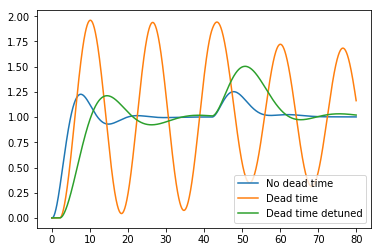

In [15]:
for description, diagram in diagrams.items():
    lastoutput = outputs[description] = diagram.simulate(ts)
    plt.plot(ts, lastoutput['y'], label=description)
plt.legend()

# Smith Predictor

The Smith predictor or dead time compensator uses a dead time free model to do most of the control ($\widetilde{G}^*$} and then subtracts the delayed prediction from the measurement to react only on the unhandled dynamics.

<img src="../../assets/smith.png" width="80%">

In [16]:
sums = {'y': ('+yd', '+yu'),
        'y-ytilde2': ('-ytilde2', '+y'),
        'e': ('+ysp', '-y-ytilde2'),
        'eprime': ('+e', '-ytilde1'),
       }

We'll use the dead time containing model from before

In [17]:
G = Gp2
G.name = 'G'

But the controller which was tuned on the dead time free model

In [18]:
Gc = Gc1
Gc.inputname = 'eprime'

In [19]:
Gtildestar = blocksim.LTI('Gtildestar', 'p', 'ytilde1',
                          1, numpy.convolve([5, 1], [3, 1]))

In [20]:
delay = blocksim.Deadtime('Delay', 'ytilde1', 'ytilde2', 2)

In [21]:
blocks = [Gc, G, Gd, Gtildestar, delay]

In [22]:
diagram = blocksim.Diagram(blocks, sums, inputs)
diagram

PI: eprime →[ Gc ]→ p
LTI: p →[ G ]→ yu
LTI: d →[ Gd ]→ yd
LTI: p →[ Gtildestar ]→ ytilde1
Deadtime: ytilde1 →[ Delay ]→ ytilde2

In [23]:
outputs['Smith compensator'] = diagram.simulate(ts)

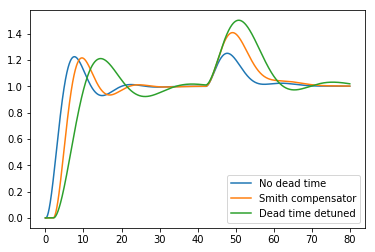

In [24]:
for description in ['No dead time', 'Smith compensator', 'Dead time detuned']:
    plt.plot(ts, outputs[description]['y'], label=description)
plt.legend()

We see that the Smith Predictor gives us almost the same performance as the dead time free system, but that it cannot entirely compensate for the delay in the disturbance output because it doesn't have an undelayed measurement of it. It still does better on the disturbance rejection than the detuned PI controller we had to settle for with the dead time.